# **Library Importation and Setup**

In this section, various Python libraries are imported to facilitate image processing, visualization, and deep learning tasks. Here's a brief explanation of the purpose of each library:

    1. NumPy and Pandas: Essential for data manipulation and analysis.
    2. Matplotlib: Used for creating static, animated, and interactive visualizations.
    3. Plotly: Enables the creation of interactive visualizations.
    4. OpenCV (cv2): A computer vision library for image and video processing.
    5. Random: Provides functions for generating pseudo-random numbers.
    6. OS and Glob: Used for interacting with the operating system and file path handling.
    7. TQDM: A progress bar library to visualize the progress of tasks.
    8. Albumentations: A library for image augmentation, crucial for enhancing model generalization.
    9. TensorFlow: An open-source machine learning framework for developing and training deep learning models.
    10. Keras: A high-level neural networks API running on top of TensorFlow, simplifying model development.
    11. Scikit-Learn: Provides tools for machine learning tasks, such as model evaluation and data splitting.
    12. VGG16 (from Keras applications): A pre-trained deep learning model often used as a feature extractor.
    13. ImageDataGenerator (from Keras.preprocessing.image): A utility for real-time data augmentation during model training.
    14. ReduceLROnPlateau and EarlyStopping (from Keras.callbacks): Callbacks for adjusting learning rates and stopping training early based on certain conditions.



This setup is crucial for efficiently handling data, developing deep learning models, and assessing model performance during training.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import cv2
import random
import os
import glob
from tqdm.notebook import tqdm
import albumentations as A
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout , BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Input, Dense, add, Conv2D, MaxPool2D ,GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping


# **Dataset Exploration and Categorization**


### Collecting Image Paths

In this cell, the script uses the glob library to gather file paths for chest X-ray images in the training, testing, and validation sets. The number of images in each set is then counted and printed.

In [ ]:
train_data = glob.glob('/content/chest-xray-pneumonia/chest_xray/train/**/*.jpeg')
test_data = glob.glob('/content/chest-xray-pneumonia/chest_xray/test/**/*.jpeg')
val_data = glob.glob('/content/chest-xray-pneumonia/chest_xray/val/**/*.jpeg')

print(f"Training Set has {len(train_data)} images")
print(f"Testing Set has {len(test_data)} images")
print(f"Validation Set has {len(val_data)} images")


Training Set has 5216 images
Testing Set has 624 images
Validation Set has 16 images


### Categorizing Images

The code further categorizes images into "NORMAL" and "PNEUMONIA" classes, providing an overview of the distribution of these classes within the dataset. This initial exploration is essential for understanding the dataset composition before subsequent analysis or model development.

In [ ]:
DIR = "/content/chest-xray-pneumonia/chest_xray/chest_xray"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")


Total Pneumonia Images: 4273
Total Normal Images: 1583


# **Basic Data Exploration :**

### Class Distribution Pie Chart

This section uses a pie chart to visualize the distribution of classes in the dataset. The dataset seems to consist of two classes: "Normal" and "Pneumonia." The chart provides a quick overview of the proportion of each class in the dataset.

In [ ]:
labels = ["Normal", "Pneumonia"]
values = [len(all_normal), len(all_pneumonia)]
colors = ['#42c8f6', '#f2ba0c']

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.5)])

fig.update_traces(
    hoverinfo='value',
    textinfo='label+percent',
    textfont_size=20,
    marker=dict(colors=colors, line=dict(color='#000000', width=3))
)

fig.update_layout(
    title="Image Category Distribution",
    titlefont={'size': 30},
    title_x=0.5,
    title_y=0.95,
)

iplot(fig)


### Shuffling Images Randomly

Here, the code shuffles the lists of images for both "Normal" and "Pneumonia" classes randomly. This is often done to ensure a balanced distribution of classes during training and testing.

In [ ]:
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
images = all_normal[:50] + all_pneumonia[:50]

### Viewing Images of X-ray

In This cell, displays a grid of X-ray images. It selects a subset of images from both classes and visualizes them in a 4x4 grid. This step is useful for getting a visual understanding of the dataset.

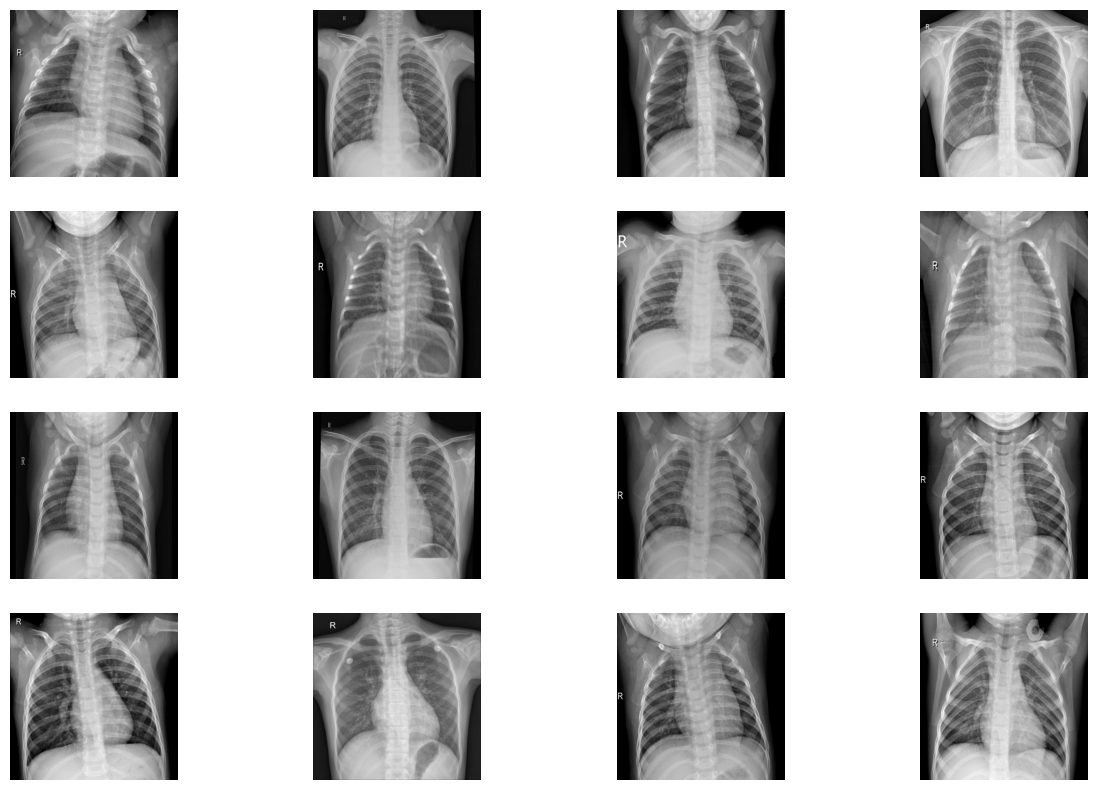

In [ ]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (1024, 1024))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

### Converting Images to Greyscale and Applying Gaussian Blur

In this section, the code converts the images to greyscale and applies a Gaussian blur. The resulting images represent the magnitude spectrum, providing insights into the areas with the majority of growth.

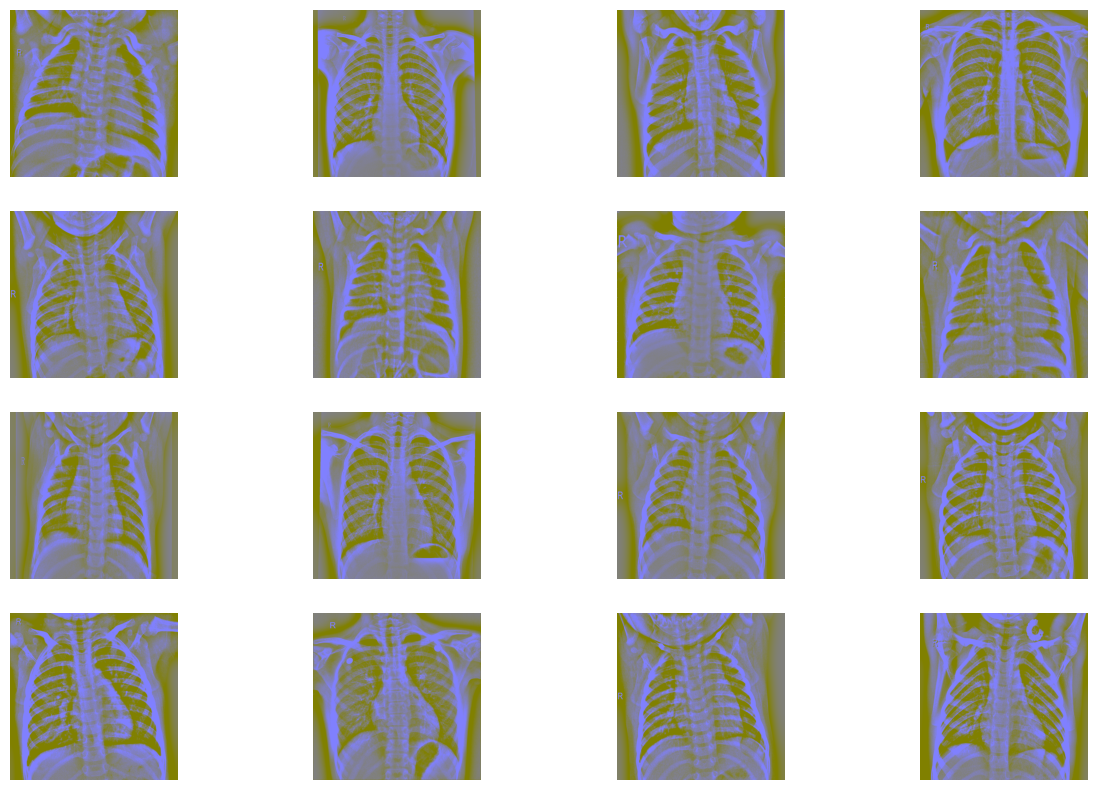

In [ ]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (1024, 1024))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

 All these images might look like a bunch of green dots on a blue background, but that’s not all. These images are basically magnitude spectrum which tells us where the majority of the growth is.


### Image Erosion

Erosion is a morphological operation that shrinks the boundaries of bright regions in an image. This code applies image erosion to a subset of images, highlighting the effect of this operation on the X-ray images.


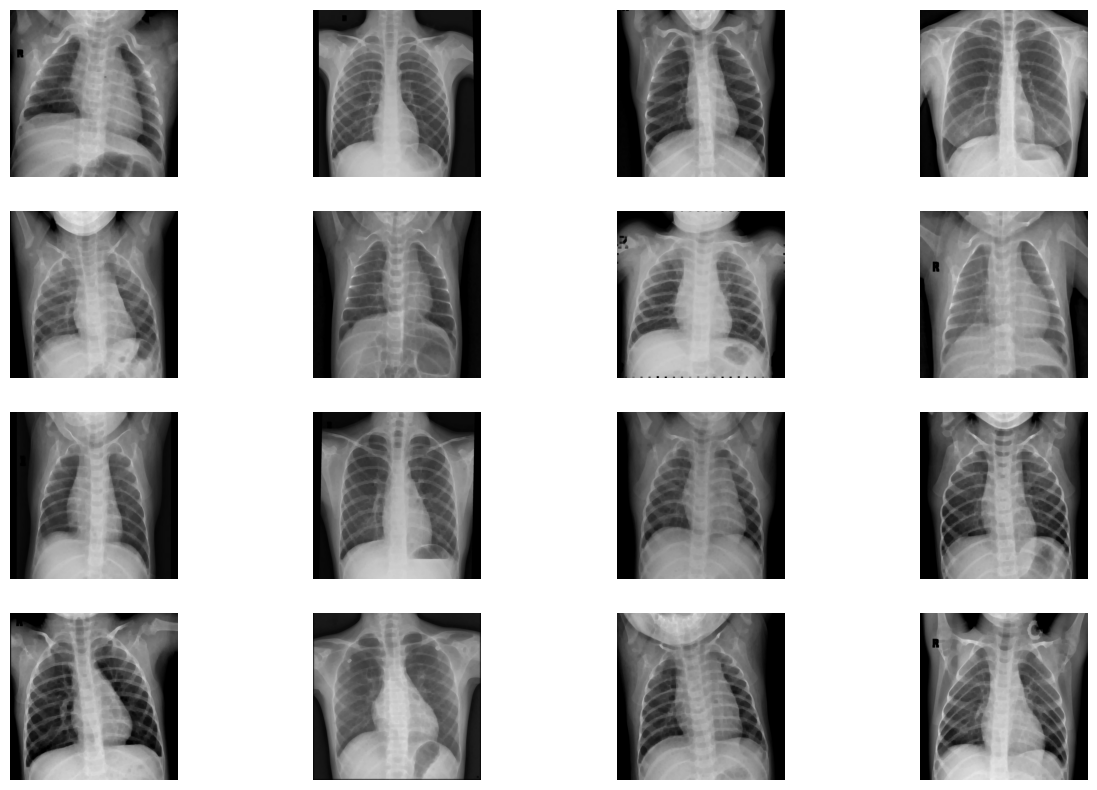

In [ ]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (1024, 1024))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

### Dilation of Images

Dilation is a morphological operation that expands the boundaries of bright regions in an image. Similar to erosion, this code applies image dilation to a subset of images, showcasing the impact of dilation on X-ray images.


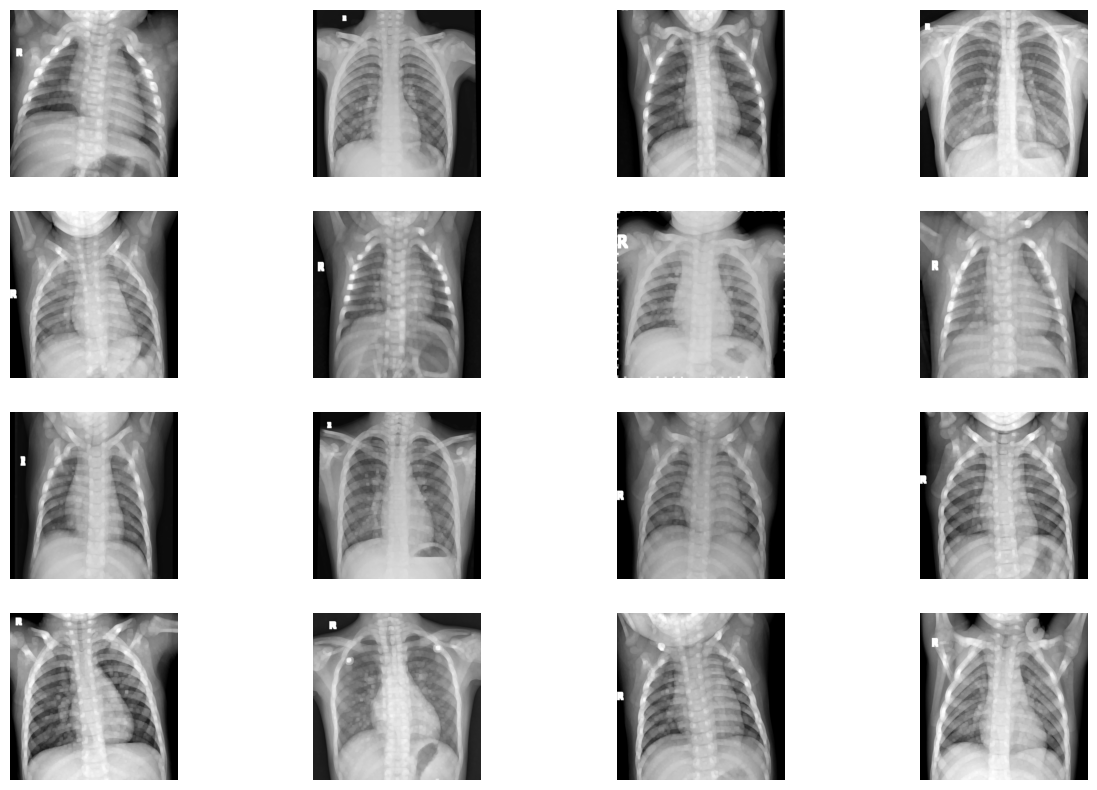

In [ ]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (1024, 1024))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)


### Edge Detection

Edge detection using the Canny algorithm is applied to a subset of images. This process highlights the edges and boundaries within the images, providing information about structural features.

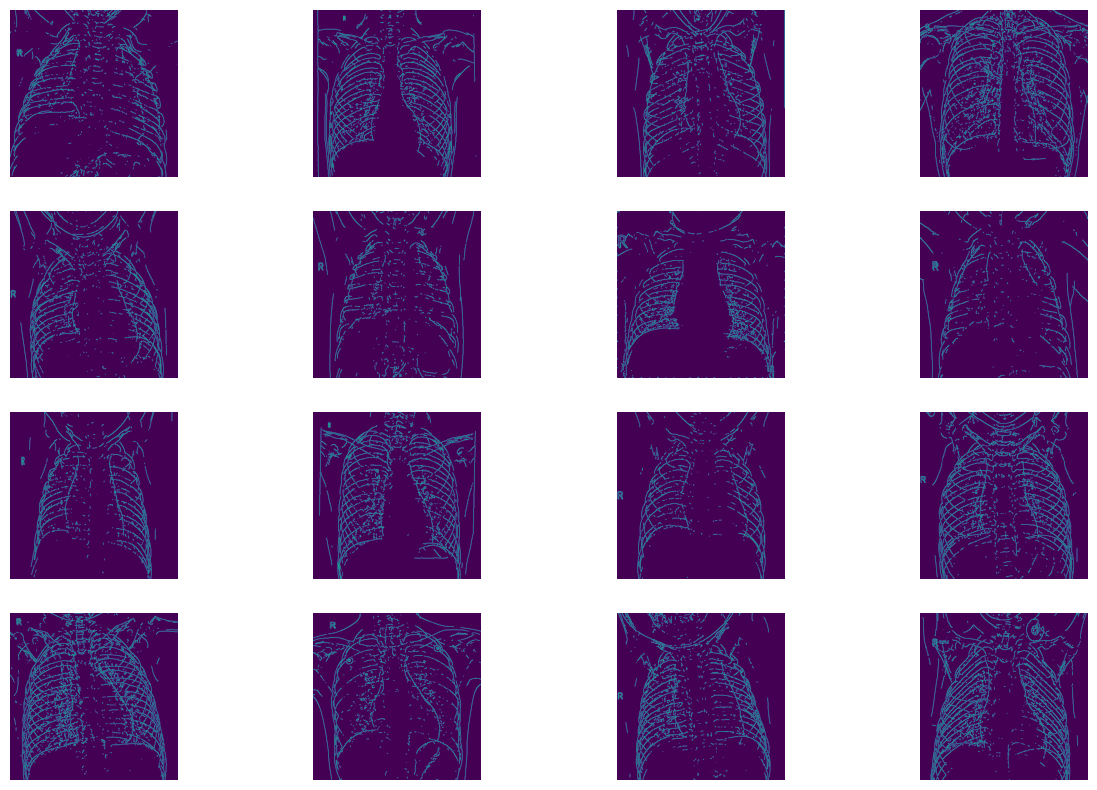

In [ ]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(edges)
    plt.axis(False)

### Image Data Generators

In this cell, ImageDataGenerators are set up for training and validation. These generators are crucial in deep learning workflows for augmenting and preprocessing image data. They perform operations like rotation, shifting, shearing, zooming, and horizontal flipping to increase the diversity of the training dataset, which can enhance model generalization.


In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(
    rescale=1./255
)


### Data Generators for Training and Validation

In this cell, the code creates data generators using the flow_from_directory method. These generators are designed to work with image datasets. The training data generator (Train) is set up to flow batches of images from the training directory, applying the transformations defined earlier. The validation data generator (val) similarly flows batches from the validation directory, but without the data augmentation transformations, only rescaling the pixel values. These generators are then used for training a deep learning model on the chest X-ray dataset.


In [ ]:
# Training data generator flow_from_directory
Train = train_gen.flow_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/train",
    batch_size=16,
    target_size=(224, 224)
)

# Validation data generator flow_from_directory
val = val_gen.flow_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/test",
    batch_size=8,
    target_size=(224, 224)
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# **Model 1**

### Model 1 Definition and Compilation

In this cell, a neural network model named Model_1 is defined using the Sequential API from Keras, a high-level neural networks API running on top of TensorFlow. The model consists of a flattening layer to reshape the input into a one-dimensional array, followed by a dense layer with 128 neurons and ReLU activation. The final layer is a dense layer with two neurons using softmax activation, indicating binary classification. The model is then compiled with the Adam optimizer, categorical crossentropy loss function, and accuracy as the evaluation metric.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

Model_1 = models.Sequential()

Model_1.add(layers.Flatten(input_shape=(224, 224,3)))

Model_1.add(layers.Dense(128, activation='relu'))

Model_1.add(layers.Dense(2, activation='softmax'))  # Binary classification

Model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])



### Model 1 Summary

The summary() method is called to display a concise summary of the model architecture, showing the layers, output shapes, and the number of parameters in each layer.

In [ ]:

Model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               19267712  
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 19267970 (73.50 MB)
Trainable params: 19267970 (73.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training the Model 1

The model is trained using the fit method on the training data (Train). The training process is monitored for the validation accuracy (val_acc), and training is stopped early if there is no improvement after 4 epochs (patience=4). The restore_best_weights parameter ensures that the model weights are restored to the ones with the best validation accuracy.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_acc', patience=4, restore_best_weights=True)

# Train the model with callbacks
history_Model_1 = Model_1.fit(
    Train,
    epochs=10,
    steps_per_epoch=50,
    validation_data=val,
    callbacks=[early_stopping_callback]
)


Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 29.2001 - accuracy: 0.6350

50/50 [==============================] - 53s 1s/step - loss: 29.2001 - accuracy: 0.6350 - val_loss: 12.3850 - val_accuracy: 0.5016
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 9.1875 - accuracy: 0.6625

50/50 [==============================] - 47s 936ms/step - loss: 9.1875 - accuracy: 0.6625 - val_loss: 15.0243 - val_accuracy: 0.6282
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 15.9438 - accuracy: 0.6538

50/50 [==============================] - 45s 898ms/step - loss: 15.9438 - accuracy: 0.6538 - val_loss: 12.9042 - val_accuracy: 0.6298
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 14.2664 - accuracy: 0.6700

50/50 [==============================] - 45s 902ms/step - loss: 14.2664 - accuracy: 0.6700 - val_loss: 18.0876 - val_accuracy: 0.6298
Epoch 5/10
50/50 [==============================] - ETA: 0s - loss: 8.4493 - accuracy: 0.7163

50/50 [==============================] - 44s 888ms/step - loss: 8.4493 - accuracy: 0.7163 - val_loss: 11.3403 - val_accuracy: 0.6426
Epoch 6/10
50/50 [==============================] - ETA: 0s - loss: 14.9391 - accuracy: 0.6438

50/50 [==============================] - 54s 1s/step - loss: 14.9391 - accuracy: 0.6438 - val_loss: 9.9066 - val_accuracy: 0.6603
Epoch 7/10
50/50 [==============================] - ETA: 0s - loss: 8.9756 - accuracy: 0.7237

50/50 [==============================] - 48s 956ms/step - loss: 8.9756 - accuracy: 0.7237 - val_loss: 24.6373 - val_accuracy: 0.6250
Epoch 8/10
50/50 [==============================] - ETA: 0s - loss: 8.7753 - accuracy: 0.7175

50/50 [==============================] - 46s 916ms/step - loss: 8.7753 - accuracy: 0.7175 - val_loss: 14.8497 - val_accuracy: 0.6298
Epoch 9/10
50/50 [==============================] - ETA: 0s - loss: 10.3055 - accuracy: 0.6888

50/50 [==============================] - 46s 914ms/step - loss: 10.3055 - accuracy: 0.6888 - val_loss: 18.5111 - val_accuracy: 0.6282
Epoch 10/10
36/50 [====================>.........] - ETA: 10s - loss: 16.4285 - accuracy: 0.6597


### Plotting Model 1 Performance

Matplotlib is used to plot the training and validation accuracy as well as the training and validation loss over epochs. The plots help visualize how well the model is learning from the training data and generalizing to the validation data. The 'accuracy' plot shows the accuracy of the model on the training and validation sets, while the 'loss' plot shows the corresponding categorical crossentropy loss values.


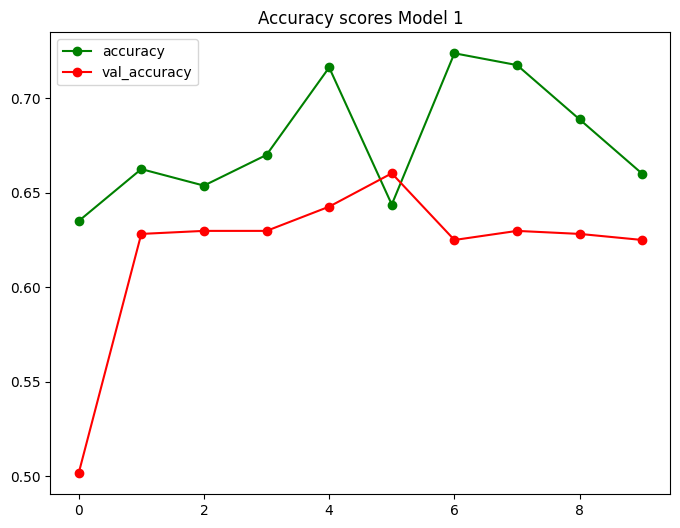

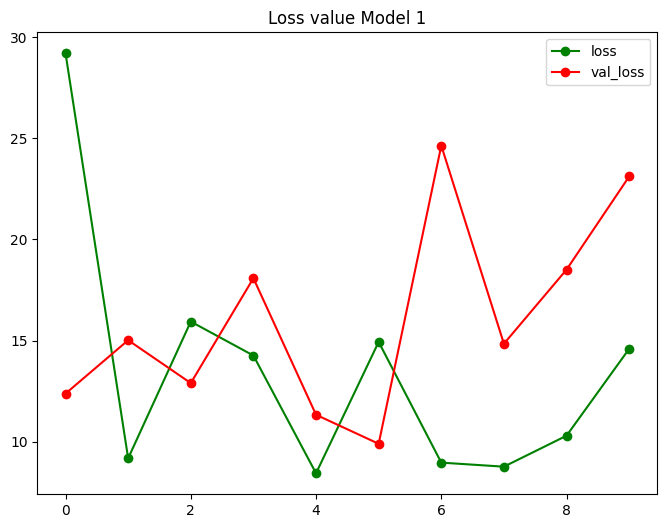

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores Model 1')
plt.plot(history_Model_1.history['accuracy'],'go-')
plt.plot(history_Model_1.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value Model 1')
plt.plot(history_Model_1.history['loss'],'go-')
plt.plot(history_Model_1.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()

# **Model 2**

### Model 2 Architecture
In this cell,code defines the architecture of a Convolutional Neural Network (CNN)using the Keras Sequential API. The model comprises three convolutional layers, each followed by a max-pooling layer to extract hierarchical features from the input images. The Flatten layer is used to transform the 3D output into a 1D array before passing it through fully connected (Dense) layers. The final layer outputs probabilities for binary classification using the softmax activation function.

In [ ]:
Model_2 = Sequential()
Model_2.add(Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=(224, 224, 3)))
Model_2.add(MaxPooling2D(pool_size=(2,2)))
Model_2.add(Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'))
Model_2.add(MaxPooling2D(pool_size=(2,2)))
Model_2.add(Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'))
Model_2.add(MaxPooling2D(pool_size=(2,2)))
Model_2.add(Flatten())

Model_2.add(Dense(128, activation='relu'))
Model_2.add(Dense(64, activation='relu'))
Model_2.add(Dense(2, activation='softmax'))


### Model 2 Summary

In this cell displays a summary of the model, providing details about the layers, output shapes, and parameters. This summary helps in understanding the overall structure of the neural network.

In [ ]:
Model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)      

### Model 2 Compilation

In this cell, the model is compiled using the Adam optimizer, categorical crossentropy loss (suitable for multi-class classification), and accuracy as the evaluation metric. Compilation is a necessary step before training the model.

In [ ]:
Model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


### Model 2 Training

In this cell trains the model using the fit_generator method, which is suitable for handling data generators. The training process is monitored by an early stopping callback, which halts training if there is no improvement in validation loss after a certain number of epochs, restoring the best weights.


In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

history_Model_2 = Model_2.fit(Train,epochs=10,validation_data=val,steps_per_epoch=50,callbacks=[early_stopping_cb])

Epoch 1/10
50/50 [==============================] - 146s 3s/step - loss: 0.5496 - accuracy: 0.7200 - val_loss: 0.5111 - val_accuracy: 0.7853
Epoch 2/10
50/50 [==============================] - 155s 3s/step - loss: 0.4445 - accuracy: 0.7675 - val_loss: 0.6494 - val_accuracy: 0.6250
Epoch 3/10
50/50 [==============================] - 156s 3s/step - loss: 0.4941 - accuracy: 0.7412 - val_loss: 0.6592 - val_accuracy: 0.6266
Epoch 4/10
50/50 [==============================] - 133s 3s/step - loss: 0.4244 - accuracy: 0.7862 - val_loss: 0.7810 - val_accuracy: 0.6250
Epoch 5/10
50/50 [==============================] - 141s 3s/step - loss: 0.4224 - accuracy: 0.7650 - val_loss: 0.5826 - val_accuracy: 0.7179
Epoch 6/10
50/50 [==============================] - 137s 3s/step - loss: 0.3672 - accuracy: 0.7887 - val_loss: 0.5404 - val_accuracy: 0.7292



### Plotting Performance

In this cell, utilizes Matplotlib to create two plots.
The first plot illustrates the training and validation accuracy over epochs, helping visualize how well the model is learning.
The second plot shows the training and validation loss, providing insights into the convergence and generalization performance of the model.


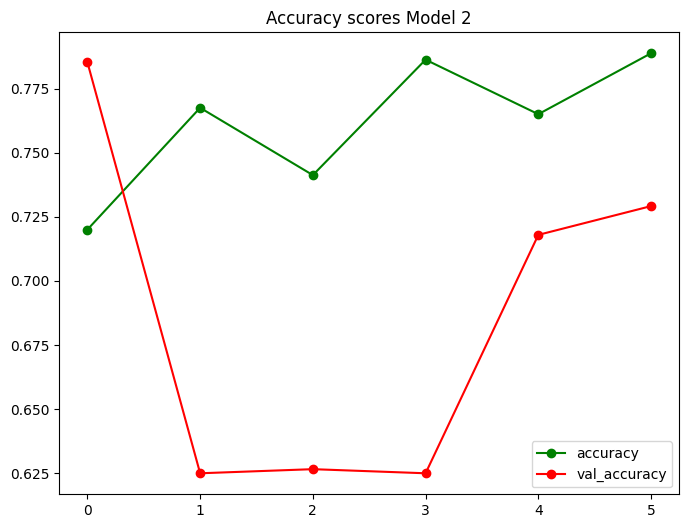

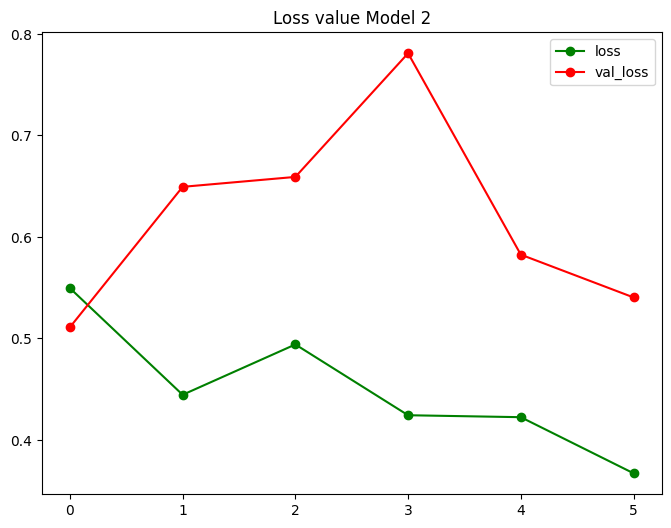

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores Model 2')
plt.plot(history_Model_2.history['accuracy'],'go-')
plt.plot(history_Model_2.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value Model 2')
plt.plot(history_Model_2 .history['loss'],'go-')
plt.plot(history_Model_2 .history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()

# **Model 3**

### Model 3 Architecture Definition

In this cell, code defines a convolutional neural network (CNN) architecture using the Keras library. It consists of convolutional layers, max-pooling layers, batch normalization, a residual block, global average pooling, dense (fully connected) layers, and dropout for regularization. The final output layer has two units with softmax activation, indicating a binary classification task.



In [ ]:
from keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, add, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

inputs = Input(shape=(224, 224, 3))

x = Conv2D(32, (3, 3), activation='elu')(inputs)
x = Conv2D(64, (3, 3), activation='elu')(x)
block_1_output = MaxPool2D(pool_size=(3, 3))(x)

x = Conv2D(64, (3, 3), activation='elu', padding='same')(block_1_output)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
block_2_output = add([x, block_1_output])

x = Conv2D(128, (3, 3), activation='elu')(block_2_output)
x = MaxPool2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='elu')(x)
x = Dropout(0.4)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=output)

In [ ]:
Model_3 = Model(inputs, output)

### Model 3 Complilation
This section compiles the model. The Adam optimizer is used with a learning rate of 0.001, categorical crossentropy is chosen as the loss function (commonly used for multi-class classification tasks), and accuracy is selected as the evaluation metric.

In [ ]:
from keras.optimizers import Adam
Model_3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


### Model 3 Summary
In this line prints a summary of the model architecture, including the layer names, types, and parameter counts.

In [ ]:
Model_3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 222, 222, 32)         896       ['input_2[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 220, 220, 64)         18496     ['conv2d_8[0][0]']            
                                                                                                  
 max_pooling2d_5 (MaxPoolin  (None, 73, 73, 64)           0         ['conv2d_9[0][0]']            
 g2D)                                                                                       

### Model 3 Training
In this cell ,The model is trained using the fit method. The training data (Train) and validation data (val) are provided. The training is performed for 10 epochs with early stopping specified by the early_stopping_cb callback to prevent overfitting. The steps_per_epoch parameter defines the number of batches processed in each epoch.

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_acc', patience=4, restore_best_weights=True)
history_Model_3 = Model_3.fit(Train,epochs=10,validation_data=val,steps_per_epoch=50,callbacks=[early_stopping_callback])

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.5143 - accuracy: 0.7575

50/50 [==============================] - 357s 7s/step - loss: 0.5143 - accuracy: 0.7575 - val_loss: 1.4268 - val_accuracy: 0.3750
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.3807 - accuracy: 0.8062

50/50 [==============================] - 356s 7s/step - loss: 0.3807 - accuracy: 0.8062 - val_loss: 0.9030 - val_accuracy: 0.4615
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.7925

50/50 [==============================] - 349s 7s/step - loss: 0.4509 - accuracy: 0.7925 - val_loss: 1.2366 - val_accuracy: 0.6266
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.7912

50/50 [==============================] - 351s 7s/step - loss: 0.4174 - accuracy: 0.7912 - val_loss: 0.5572 - val_accuracy: 0.7372
Epoch 5/10
50/50 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.8400

50/50 [==============================] - 354s 7s/step - loss: 0.3435 - accuracy: 0.8400 - val_loss: 0.5489 - val_accuracy: 0.7340
Epoch 6/10
50/50 [==============================] - ETA: 0s - loss: 0.3820 - accuracy: 0.8200

50/50 [==============================] - 359s 7s/step - loss: 0.3820 - accuracy: 0.8200 - val_loss: 3.0552 - val_accuracy: 0.6250
Epoch 7/10
50/50 [==============================] - ETA: 0s - loss: 0.3668 - accuracy: 0.8462

50/50 [==============================] - 323s 6s/step - loss: 0.3668 - accuracy: 0.8462 - val_loss: 0.5643 - val_accuracy: 0.7388
Epoch 8/10
50/50 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.8413

50/50 [==============================] - 351s 7s/step - loss: 0.3439 - accuracy: 0.8413 - val_loss: 0.5924 - val_accuracy: 0.7660
Epoch 9/10
50/50 [==============================] - ETA: 0s - loss: 0.3229 - accuracy: 0.8512

50/50 [==============================] - 325s 7s/step - loss: 0.3229 - accuracy: 0.8512 - val_loss: 1.2615 - val_accuracy: 0.6587
Epoch 10/10
50/50 [==============================] - ETA: 0s - loss: 0.3332 - accuracy: 0.8550

50/50 [==============================] - 358s 7s/step - loss: 0.3332 - accuracy: 0.8550 - val_loss: 1.8253 - val_accuracy: 0.3830


### Plotting Model 3
These plots visualize the training history of the model. The first plot shows the accuracy and validation accuracy over epochs, while the second plot shows the training loss and validation loss over epochs. These visualizations help in assessing the model's performance and identifying potential issues such as overfitting or underfitting.

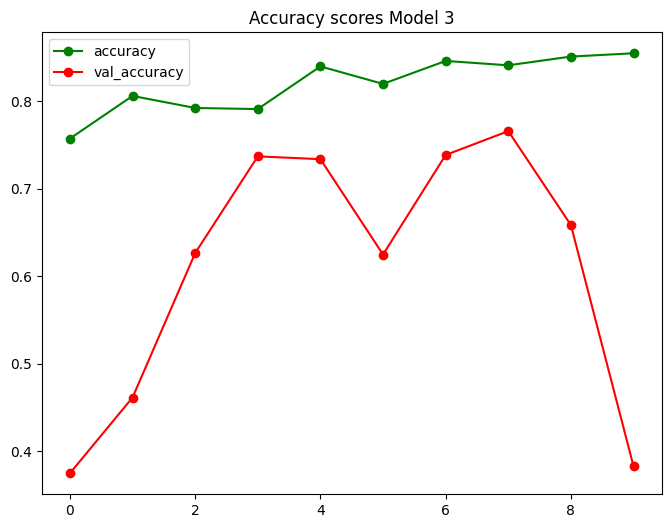

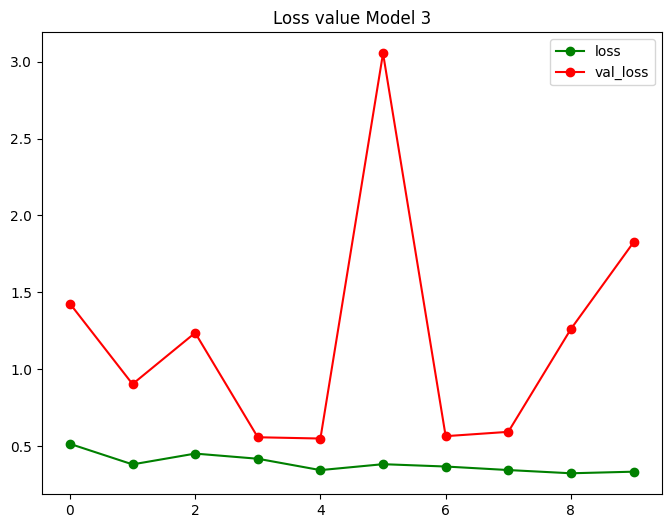

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores Model 3')
plt.plot(history_Model_3.history['accuracy'],'go-')
plt.plot(history_Model_3.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value Model 3')
plt.plot(history_Model_3.history['loss'],'go-')
plt.plot(history_Model_3.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()

# Conclusion

Three different models were implemented and evaluated for a binary image classification task on chest X-ray data. Model 1 is a simple neural network, Model 2 is a convolutional neural network, and Model 3 is a more complex CNN with residual connections. Training histories and performance metrics were visualized for each model. Further analysis and comparison of the models' performance could provide insights into their effectiveness for the given classification task.